<h2>Calculates the CHARIS major basin area by elevations</h2>


In [1]:
%pylab notebook
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as md
#from nose.tools import set_trace
from charistools.convertors import Dem2Hypsometry
from charistools.convertors import Modice2Hypsometry
from charistools.hypsometry import Hypsometry
from charistools.meltModels import TriSurfTempIndexMelt
from charistools.meltModels import ImshowTriSurfMelt
from charistools.meltModels import PlotTriSurfInput
from charistools.meltModels import PlotTriSurfMelt
from charistools.modelEnv import ModelEnv
from charistools.timeSeries import TimeSeries
import pandas as pd
import re
import seaborn as sns
import os
sns.set()
sns.axes_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0,
 'xtick.minor.size': 0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0,
 'ytick.minor.size': 0}

In [2]:
configFile = '/Users/brodzik/ipython_notebooks/charis/calibration_modelEnv_config.ini'
myEnv = ModelEnv(tileConfigFile=configFile)

# reset basin mask directory  and filename patterns slightly
print("Before:")
print(myEnv.tileConfig['input']['fixed']['basin_mask']['dir'])
print(myEnv.tileConfig['input']['fixed']['basin_mask']['pattern'])
print(myEnv.tileConfig['hypsometry']['area_by_elevation']['dir'])
print(myEnv.tileConfig['hypsometry']['modice_min05yr_by_elevation']['dir'])

myEnv.tileConfig['input']['fixed']['basin_mask']['dir'] = "%MODEL_TOP_DIR%/basins/major_basins_from_GRDC/MODIStiles"
myEnv.tileConfig['input']['fixed']['basin_mask']['pattern'] = "%DRAINAGEID%_%TILEID%.tif"
myEnv.tileConfig['hypsometry']['area_by_elevation']['dir'] = "%MODEL_TOP_DIR%/derived_hypsometries/REECv0/basin_areas"
myEnv.tileConfig['hypsometry']['modice_min05yr_by_elevation']['dir'] = "%MODEL_TOP_DIR%/derived_hypsometries/REECv0/basin_areas"

print("After:")
print(myEnv.tileConfig['input']['fixed']['basin_mask']['dir'])
print(myEnv.tileConfig['input']['fixed']['basin_mask']['pattern'])
print(myEnv.tileConfig['hypsometry']['area_by_elevation']['dir'])
print(myEnv.tileConfig['hypsometry']['modice_min05yr_by_elevation']['dir'])

Before:
%MODEL_TOP_DIR%/basins/calibration_basins/from_summit
%DRAINAGEID%.basin_mask.%TILEID%.tif
%MODEL_TOP_DIR%/derived_hypsometries
%MODEL_TOP_DIR%/derived_hypsometries/%DRAINAGEID%
After:
%MODEL_TOP_DIR%/basins/major_basins_from_GRDC/MODIStiles
%DRAINAGEID%_%TILEID%.tif
%MODEL_TOP_DIR%/derived_hypsometries/REECv0/basin_areas
%MODEL_TOP_DIR%/derived_hypsometries/REECv0/basin_areas


In [3]:
# Basins with endorheic holes filled in
#majorBasinIDs = ["SY_SyrDarya_at_TyumenAryk",
#                 "AM_AmuDarya_at_Chatly_noholes",
#                 "IN_Indus_at_Kotri_nolobe_gcs_noholes",
#                 "GA_Ganges_at_Paksey",
#                 "BR_Bramaputra_at_Bahadurabad_noholes"]
# GRDC Basins, Indus corrected for lobe
#majorBasinIDs = ["SY_SyrDarya_at_TyumenAryk",
#                 "AM_AmuDarya_at_Chatly",
#                 "IN_Indus_at_Kotri",
#                 "GA_Ganges_at_Paksey",
#                 "BR_Bramaputra_at_Bahadurabad"]
majorBasinIDs = ["SY_SyrDarya_at_TyumenAryk",
                 "AM_AmuDarya_at_Chatly",
                 #"AM_AmuDarya_at_Chatly_noholes",
                 "IN_Indus_at_Kotri",
                 "IN_Indus_at_Kotri_nolobe",
                 #"IN_Indus_at_Kotri_nolobe_gcs_noholes",
                 "GA_Ganges_at_Paksey",
                 "BR_Bramaputra_at_Bahadurabad"]
                 #"BR_Bramaputra_at_Bahadurabad_noholes"]
majorBasinNames = ["SY (GRDC)",
                   "AM (GRDC)",
                   #"AM (GRDC holes filled)",
                   "IN (GRDC)",
                   "IN (GRDC no lobe)",
                   #"IN (GRDC no lobe, holes filled)",
                   "GA (GRDC)",
                   "BR (GRDC)"]
                   #"BR (GRDC holes filled)"]
majorBasinIDs


['SY_SyrDarya_at_TyumenAryk',
 'AM_AmuDarya_at_Chatly',
 'IN_Indus_at_Kotri',
 'IN_Indus_at_Kotri_nolobe',
 'GA_Ganges_at_Paksey',
 'BR_Bramaputra_at_Bahadurabad']

In [4]:
#print(ModelEnv.tileIDs_for_drainage(myEnv, drainageID=majorBasinIDs[4]))
#print(myEnv.hypsometry_filename(type='area_by_elevation', 
#                                contour_m=50,
#                                drainageID=majorBasinIDs[0]))
#print(myEnv.hypsometry_filename(type='modice_min05yr_by_elevation', 
#                          drainageID=majorBasinIDs[0], modice_nstrikes=3))

In [8]:
verbose = False
contour_m = 100

In [ ]:
for id in majorBasinIDs:
    outFile = myEnv.hypsometry_filename(type='area_by_elevation', 
                                        contour_m=contour_m,
                                        drainageID=id)
    print("DEM   : %s" % outFile)
    hyps = Dem2Hypsometry(id, myEnv, contour_m=contour_m,
                          outfile=outFile, decimal_places=4,
                          verbose=verbose)
    print("Total masked area = %f" % hyps.data.sum().sum())
    for n in np.arange(3):
        outFile = myEnv.hypsometry_filename(type='modice_min05yr_by_elevation', 
                                            drainageID=id,
                                            contour_m=contour_m,
                                            modice_nstrikes=n+1)
        print("MODICE: %d : %s" % (n, outFile))
        hyps = Modice2Hypsometry(id, myEnv, contour_m=contour_m,
                                 modice_nstrikes=n+1,
                                 outfile=outFile, 
                                 decimal_places=4, 
                                 verbose=verbose)

In [5]:
my_series = pd.Series(majorBasinIDs)
df = pd.DataFrame(my_series)
df.columns = ['Basin']
df.set_index('Basin', inplace=True)
#df["Name"] = ["Syr Darya", "Amu Darya", "Indus", "Ganges", "Brahmaputra"]
df["Name"] = majorBasinNames
df

,Name
Basin,
SY_SyrDarya_at_TyumenAryk,SY (GRDC)
AM_AmuDarya_at_Chatly,AM (GRDC)
IN_Indus_at_Kotri,IN (GRDC)
IN_Indus_at_Kotri_nolobe,IN (GRDC no lobe)
GA_Ganges_at_Paksey,GA (GRDC)
BR_Bramaputra_at_Bahadurabad,BR (GRDC)


In [6]:
outdir = "/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas"

<IPython.core.display.Javascript object>


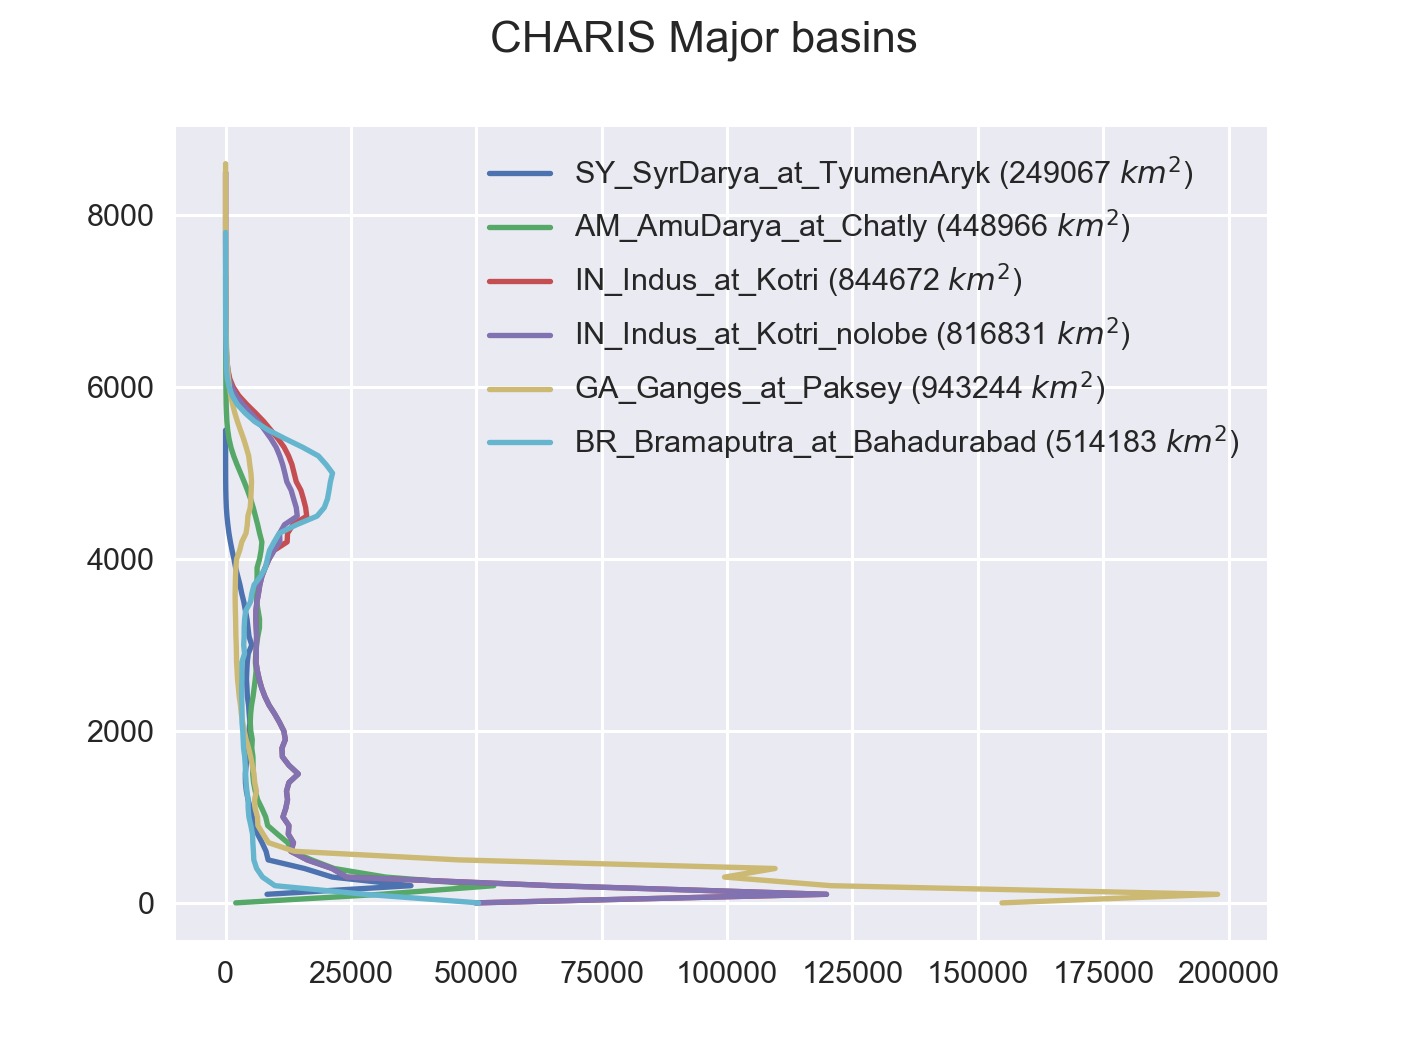

/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/SY_SyrDarya_at_TyumenAryk.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/AM_AmuDarya_at_Chatly.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/IN_Indus_at_Kotri.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/IN_Indus_at_Kotri_nolobe.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/GA_Ganges_at_Paksey.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/BR_Bramaputra_at_Bahadurabad.0100m.area_by_elevation.txt


In [9]:
fig, axes = plt.subplots(1)
for id in majorBasinIDs:
    outFile = myEnv.hypsometry_filename(type='area_by_elevation', 
                                        contour_m=contour_m,
                                        drainageID=id)
    print(outFile)
    hyps = Hypsometry(outFile)
    label = "%s (%d $km^2$)" % (id, hyps.data.sum().sum())
    df.ix[id,'Basin Area (km2)'] = hyps.data.sum().sum()
    axes.plot(hyps.data.loc['NoDate'].values,
              np.array(hyps.data.loc['NoDate'].index),
              label=label)
    axes.legend()
fig.suptitle('CHARIS Major basins')
fig.savefig("%s/%s" % (outdir, "CHARIS_basins_area_by_elevation.png"))

In [10]:
df

,Name,Basin Area (km2)
Basin,,
SY_SyrDarya_at_TyumenAryk,SY (GRDC),249067.6007
AM_AmuDarya_at_Chatly,AM (GRDC),448966.9877
IN_Indus_at_Kotri,IN (GRDC),844672.8654
IN_Indus_at_Kotri_nolobe,IN (GRDC no lobe),816831.2063
GA_Ganges_at_Paksey,GA (GRDC),943244.3428
BR_Bramaputra_at_Bahadurabad,BR (GRDC),514183.9421


<IPython.core.display.Javascript object>


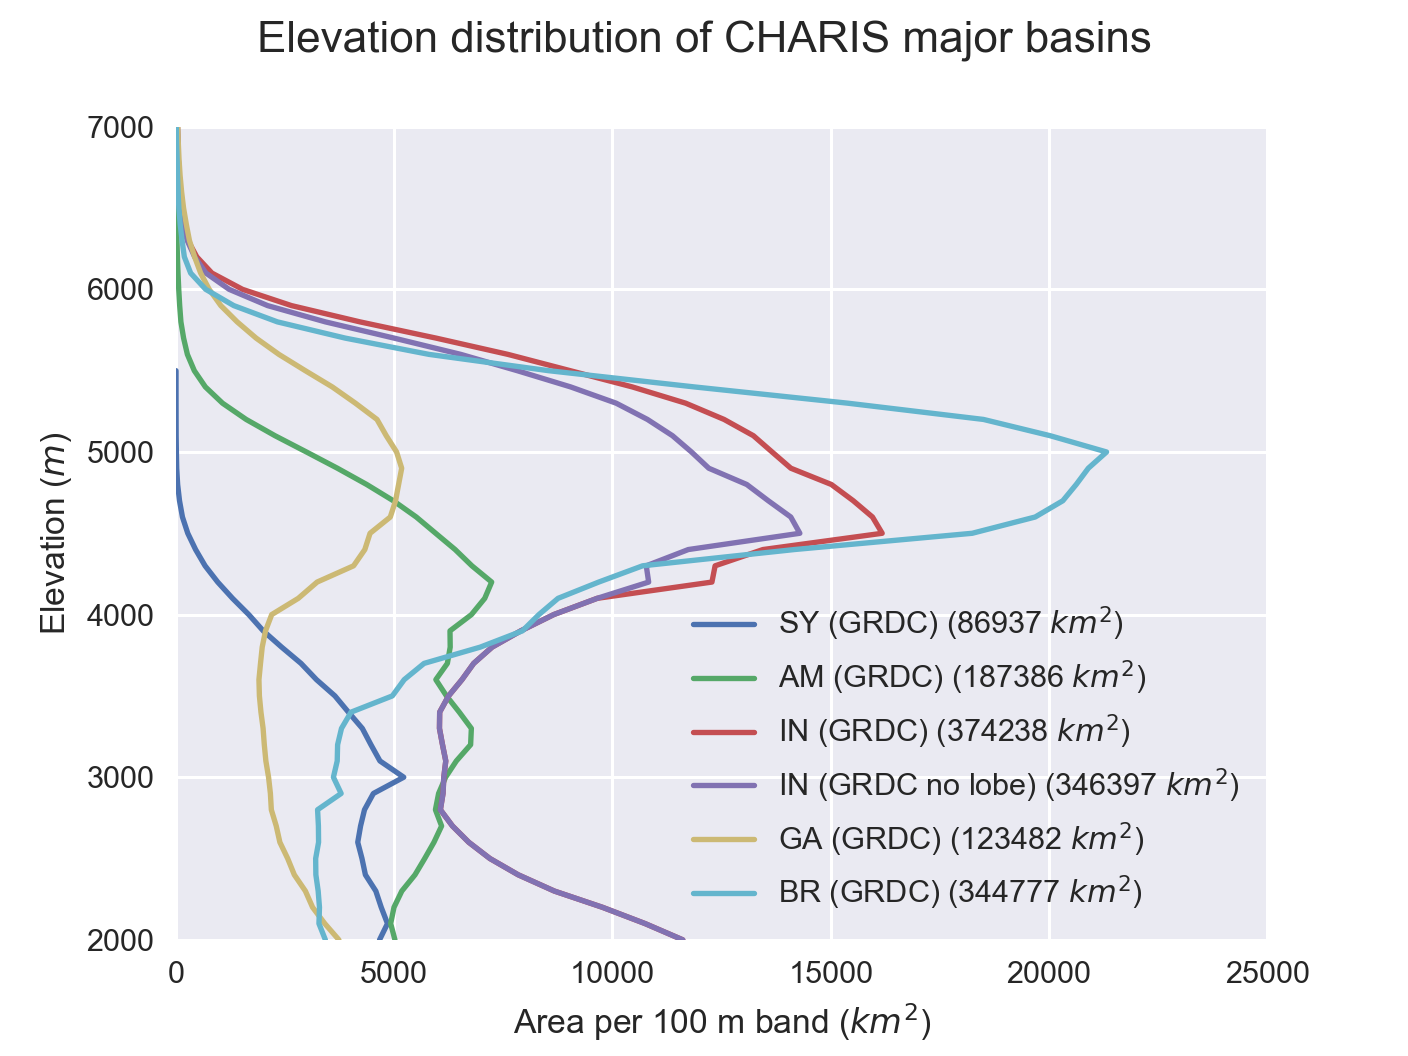

/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/SY_SyrDarya_at_TyumenAryk.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/AM_AmuDarya_at_Chatly.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/IN_Indus_at_Kotri.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/IN_Indus_at_Kotri_nolobe.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/GA_Ganges_at_Paksey.0100m.area_by_elevation.txt
/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/BR_Bramaputra_at_Bahadurabad.0100m.area_by_elevation.txt


In [11]:
limit_m = 2000
fig, axes = plt.subplots()
for id in majorBasinIDs:
    outFile = myEnv.hypsometry_filename(type='area_by_elevation', 
                                        contour_m = contour_m,
                                        drainageID=id)
    print(outFile)
    hyps = Hypsometry(outFile)
    hyps.data.drop(hyps.data.columns[hyps.data.columns < limit_m], axis=1, inplace=True)
    label = "%s (%d $km^2$)" % (df.Name.loc[id], hyps.data.sum().sum())
    df.ix[id,'Basin Area > %dm (km2)' % limit_m] = hyps.data.sum().sum()
    axes.plot(hyps.data.loc['NoDate'].values,
              np.array(hyps.data.loc['NoDate'].index),
              label=label)

axes.set_xlabel("Area per %d m band ($km^2$)" % contour_m)
axes.set_ylabel("Elevation ($m$)")
axes.set_xlim([0., 25000.])
axes.set_ylim([2000., 7000.])
axes.legend()
fig.suptitle('Elevation distribution of CHARIS major basins')
fig.savefig("%s/CHARIS_basin_area_by_elevation.above%dm.v1.png" % (outdir, limit_m))

In [12]:
contour_m = 100
limit_m = 2000
for id in majorBasinIDs:
    for n in np.arange(3) + 1:
        outFile = myEnv.hypsometry_filename(type='modice_min05yr_by_elevation', 
                                            drainageID=id,
                                            contour_m=contour_m,
                                            modice_nstrikes=n)
        print("MODICE: %d : %s" % (n, outFile))

        hyps = Hypsometry(outFile)
        hyps.data.drop(hyps.data.columns[hyps.data.columns < limit_m],
                       axis=1, inplace=True)
        print(" Total MODICE area (>2000): %f" % hyps.data.sum().sum())
        
        df.ix[id,'MODICE (%dstr) Area > %dm (km2)' % (n, limit_m)] = hyps.data.sum().sum()

print(df)


MODICE: 1 : /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/SY_SyrDarya_at_TyumenAryk.0100m.modicev04_1strike_area_by_elev.txt
 Total MODICE area (>2000): 1938.153200
MODICE: 2 : /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/SY_SyrDarya_at_TyumenAryk.0100m.modicev04_2strike_area_by_elev.txt
 Total MODICE area (>2000): 2540.270600
MODICE: 3 : /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/SY_SyrDarya_at_TyumenAryk.0100m.modicev04_3strike_area_by_elev.txt
 Total MODICE area (>2000): 3009.729300
MODICE: 1 : /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/AM_AmuDarya_at_Chatly.0100m.modicev04_1strike_area_by_elev.txt
 Total MODICE area (>2000): 10362.647300
MODICE: 2 : /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas/AM_AmuDarya_at_Chatly.0100m.modicev04_2strike_area_by_elev.txt
 Total MODICE area (>2000): 12899.269100
MODICE: 3 : /Users/brodzik/projects/CHARIS/derived_hypso

In [13]:
df


,Name,Basin Area (km2),Basin Area > 2000m (km2),MODICE (1str) Area > 2000m (km2),MODICE (2str) Area > 2000m (km2),MODICE (3str) Area > 2000m (km2)
Basin,,,,,,
SY_SyrDarya_at_TyumenAryk,SY (GRDC),249067.6007,86937.4069,1938.1532,2540.2706,3009.7293
AM_AmuDarya_at_Chatly,AM (GRDC),448966.9877,187386.9331,10362.6473,12899.2691,14608.3814
IN_Indus_at_Kotri,IN (GRDC),844672.8654,374238.7223,26828.9002,31756.3897,35400.2209
IN_Indus_at_Kotri_nolobe,IN (GRDC no lobe),816831.2063,346397.0632,26281.5204,31108.5498,34670.5961
GA_Ganges_at_Paksey,GA (GRDC),943244.3428,123482.8311,9612.4154,11484.0245,12953.3630
BR_Bramaputra_at_Bahadurabad,BR (GRDC),514183.9421,344777.8927,15760.4545,21648.3279,26893.2976


In [14]:
csvfile = "%s/CHARIS_basin_area_summary.csv" % outdir
df.to_csv(csvfile)

In [15]:
outdir


'/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0/basin_areas'